其中，$(-\beta_1x_{i,1})$被$(-\beta_1(\delta_{i,1,1}WOE_{1,1}+\delta_{i,1,2}WOE_{1,2}+...+\delta_{i,1,k_{1}}WOE_{1,k_{1}}))$替换。$x_{i,1}$是第$i$个样本的第$1$个属性变量，这个数量变量在分段阶段被分为$k_1$段，$WOE_{1,k_{1}}$表示第$k_1$段的$WOE$。$\delta_{i,1,1}$表示，如果变量$x_{i,1}$的值在第1个分段，那么$\delta_{i,1,1}=1$，如果变量$x_{i,1}$的值不在第1个分段，$\delta_{i,1,1}=0$，这个变量的目的是让公式$(???)$的形式整齐。其他以此类推。

对于第一个属性，如果它的值在该第一个分段，增加分值$-\beta_1\delta_{1,1}WOE_{1,1}$，如果它的值在第二个分段，增加分值$-\beta_1\delta_{1,2}WOE_{1,2}$...，由此，计算出第一个属性对应的分值，然后累加到基础分上。

# 1.前言
在银行借贷场景中，评分卡是一种以分数形式来衡量一个客户的信用风险大小的手段，它衡量向受信人或需要融资的公司不能如期履行合同中的还本付息责任和让授信人或银行等金融机构造成经济损失的可能性的一种方式。一般来说，评分卡打出的分数越高，客户的信用越好，风险越小。

这些”借钱的人“，可能是个人，有可能是有需求的公司和企业。对于企业来说，我们按照融资主体的融资用途，分别使用企业融资模型，现金流融资模型，项目融资模型等模型。而对于个人来说，我们有”四张卡“来评判个人的信用程度：A卡，B卡，C卡和F卡。而众人常说的“评分卡”其实是指A卡，又称为申请者评级模型，主要应用于相关融 资类业务中新用户的主体评级，即判断金融机构是否应该借钱给一个新用户，如果这个人的风险太高，我们可以拒绝贷款。

本项目使用的数据集由[kaggle提供](https://link.zhihu.com/?target=https%3A//www.kaggle.com/c/GiveMeSomeCredit/data)
[数据集下载地址](https://www.jianshu.com/p/b94036ec839f)

SeriousDlqin2yrs：超过90天或更糟的逾期拖欠

RevolvingUtilization Of UnsecuredLines：无担保放款的循环利用：除了不动产和像车 贷那样除以信用额度总和的无分期付款债务的信用卡和个人信用额度总额

Age：借款人年龄

NumberOfTime30-59DaysPastDueNotWorse：30-59天逾期次数

DebtRatio：负债比例

MonthlyIncome：月收入

Number Of OpenCreditLinesAndLoans：贷款数量

NumberOfTimes90DaysLate：90天逾期次数：借款者有90天或更高逾期的次数

NumberReal Estate Loans Or Lines：不动产贷款或额度数量：抵押贷款和不动产放款包 括房屋净值信贷额度

Number Of Time 60-89Days PastDue Not Worse：60-89天逾期次数

NumberOfDependents：不包括本人在内的家属数量
首先是基于个人借贷的场景，确定“违约”的定义： 根据新的Basel II Capital Accord（巴塞尔二资本协议），一般逾期90天算作违约。

# 2.数据预处理

## 2.1 读取数据以及导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
import pandas as pd
#读取寻训练数据，为了使不同的端可以正常使用数据，故设置两段读取
#从kaggle训练集库读取
try:
    path = "E:\kaggledatabase\GiveMeSomeCredit\\"
    data = pd.read_csv(path+"cs-training.csv",index_col=0)#设置某列作为索引
except FileNotFoundError:#除非找不到文件，再从该目录下查找文件
    data = pd.read_csv("cs-training.csv",index_col=0)#设置某列作为索引

## 2.2 数据预处理

### 2.2.1 观察数据结构

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


十个特征，一个被解释变量

### 2.2.2 去除重复值

现实数据，尤其是银行业数据，可能会存在的一个问题就是样本重复，即有超过一行的样本所显示的所有特征都一样。有时候可能时人为输入重复，有时候可能是系统录入重复，总而言之我们必须对数据进行去重处理。可能有人会说，难道不可能出现说两个样本的特征就是一模一样，但他们是两个样本吗？比如，两个人，一模一样的名字，年龄，性别，学历，工资……当特征量很少的时候，这的确是有可能的，但一些指标，比如说家属人数，月收入，已借有的房地产贷款数量等等，几乎不可能都出现一样。尤其是银行业数据经常是几百个特征，所有特征都一样的可能性是微乎其微的。即便真的出现了如此极端的情况，我们也可以当作是少量信息损失，将这条记录当作重复值除去。

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [4]:
#去除重复值
#inplace=True表示替换原数据
data.drop_duplicates(inplace=True)#当两行数据完全一样就删除
#删除完记得恢复索引
data.index = range(data.shape[0])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


### 2.2.3 探索缺失值

第二个要面临的问题，就是缺失值。在这里我们需要填补的特征是“月收入”和“家属人数”。“家属人数”缺失很少，仅缺失了大约2.5%，可以考虑直接删除，或者使用均值来填补。“收入”缺失了几乎20%，并且我们知道，“收入”必然是 一个对信用评分来说很重要的因素，因此这个特征必须要进行填补。在这里，我们使用均值填补“家属人数”。

In [6]:
#查看缺失值比例
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [7]:
#使用均值填补“家属”缺失值
data['NumberOfDependents'].fillna(int(data['NumberOfDependents'].mean()),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      149391 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [8]:
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000000
dtype: float64

那字段"月收入"怎么办呢？对于银行数据来说，我们甚至可以有这样的推断：一个来借钱的人应该是会知道，“高收入”或者“稳定收入”于他/她自己而言会是申请贷款过程中的一个助力，因此如果收入稳定良好的人，肯定会倾向于写上自己的收入情况，那么这些“收入”栏缺失的人，更可能是收入状况不稳定或收入比较低的人。基于这种判断，我们可以用比如说，四分位数来填补缺失值，把所有收入为空的客户都当成是低收入人群。当然了，也有可能这些缺失是银行数据收集过程中的失误，我们并无法判断为什么收入栏会有缺失，所以我们的推断也有可能是不正确的。具体采用什么样的手段填补缺失值，要和业务人员去沟通，观察缺失值是如何产生的。

在这里，我们使用随机森林填补“月收入”。 随机森林利用“既然我可以使用A，B，C去预测Z，那我也可以使用A，C，Z去预测B”的思想来填补缺失值。这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新的特征矩阵。在新的特征矩阵中，它没有缺失的部分，就是我们的训练集，这部分数据既有标签也有特征，而它缺失的部分，只有特征没有标签，就是我们需要预测的部分。

特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train

特征T不缺失的值：Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test

特征T缺失的值：未知，我们需要预测的Y_test
![新的特征矩阵](https://img-blog.csdnimg.cn/20200918231243334.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80Mzk2NjkwMA==,size_16,color_FFFFFF,t_70#pic_center)

#### 使用随机森林填补一个特征的缺失值的函数

In [9]:
def fill_missing_rf(X,y,to_fill):

    """
    使用随机森林填补一个特征的缺失值的函数

    参数：
    X：要填补的特征矩阵
    y：完整的，没有缺失值的标签
    to_fill：字符串，要填补的那一列的名称
    """

    #构建新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)

    # 找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.loc[Ytrain.index,:]
    Xtest = df.loc[Ytest.index,:]

    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)

    return Ypredict

In [10]:
X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]

#将参数输入函数
y_pred = fill_missing_rf(X,y,"MonthlyIncome")

In [11]:
y_pred.shape

(29221,)

In [12]:
data.loc[data.loc[:,'MonthlyIncome'].isnull(),"MonthlyIncome"].shape

(29221,)

In [13]:
#查看预测出来的与原来的缺失值数量是否对的上
y_pred.shape == data.loc[data.loc[:,'MonthlyIncome'].isnull(),"MonthlyIncome"].shape

True

In [14]:
#进行覆盖
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

In [15]:
data.to_csv("nonull.csv")

In [16]:
data.info()
#留一个拷贝
data_cp = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           149391 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      149391 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


# 2.2.4 异常值的处理
现实数据永远都会有一些异常值，首先我们要去把他们捕捉出来，然后观察他们的性质。注意，我们并不是要排除掉所有异常值，相反很多时候，异常值是我们的重点研究对象，比如说，双十一中购买量超高的品牌，或课堂上让很多学生都兴奋的课题，这些是我们要重点研究观察的。

日常处理异常值，我们使用箱线图或者3σ法则来找到异常值。但在银行数据中，我们希望排除的“异常值”不是一些超高或超低的数字，而是一些不符合常理的数据：比如，收入不能为负数，但是一个超高水平的收入却是合理的，可以存在的。所以在银行业中，我们往往就使用普通的描述性统计来观察数据的异常与否与数据的分布情况。注意，这种方法只能在特征量有限的情况下进行，如果有几百个特征又无法成功降维或特征选择不管用，那还是用3σ比较好。

In [17]:
#描述性统计
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5425.462916,13245.408948,0.0,0.0,0.180000,1800.000000,4420.000000,7416.000000,10800.000000,23250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


异常值也被我们观察到，年龄的最小值居然有0，这不符合银行的业务需求，即便是儿童账户也要至少8岁，我们可以查看一下年龄为0的人有多少，发现只有1个人年龄为0，可以判断这肯定是录入失误造成的，可以当成是缺失值来处理，直接删除掉这个样本。

In [18]:
(data['age'] == 0).sum()
data  = data[data['age'] != 0]

另外，有三个指标看起来很奇怪： "NumberOfTime30-59DaysPastDueNotWorse" 、"NumberOfTime60-89DaysPastDueNotWorse"、 "NumberOfTimes90DaysLate" 这三个指标分别是“过去两年内出现35-59天逾期但是没有发展的更坏的次数”，“过去两年内出现60-89天逾期但是没 有发展的更坏的次数”，“过去两年内出现90天逾期的次数”。这三个指标，在99%的分布的时候依然是2，最大值却是 98，看起来非常奇怪。一个人在过去两年内逾期35~59天98次，一年6个60天，两年内逾期98次这是怎么算出来的？ 我们可以去咨询业务人员，请教他们这个逾期次数是如何计算的。如果这个指标是正常的，那这些两年内逾期了98次的客户，应该都是坏客户。

In [19]:
#在我们无法询问他们情况下，我们查看一下有多少个样本存在这种异常：  
(data['NumberOfTime30-59DaysPastDueNotWorse'] > 15).sum()

225

In [20]:
(data['NumberOfTimes90DaysLate'] > 90).sum()

225

In [21]:
(data['NumberOfTime60-89DaysPastDueNotWorse'] > 90).sum()

225

3类异常样本数量全都一样，会不会全是同一组样本？

In [22]:
df = data[data['NumberOfTime30-59DaysPastDueNotWorse'] > 90]

In [23]:
df = df[df['NumberOfTimes90DaysLate'] > 90]

In [24]:
df = df[df['NumberOfTime60-89DaysPastDueNotWorse'] > 90]

In [25]:
df.shape

(225, 11)

In [26]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1732,1,1.0,27,98,0.0,2700.000000,0,98,0,98,0.0
2285,0,1.0,22,98,0.0,1393.251044,0,98,0,98,0.0
3883,0,1.0,38,98,12.0,2519.070000,0,98,0,98,0.0
4416,0,1.0,21,98,0.0,0.000000,0,98,0,98,0.0
4704,0,1.0,21,98,0.0,2000.000000,0,98,0,98,0.0


In [27]:
df.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,225.0,0.604444,4.900599e-01,0.0,0.0,0.0,0.000,1.0,1.000000,1.000000,1.00,1.0
RevolvingUtilizationOfUnsecuredLines,225.0,1.000000,4.005714e-15,1.0,1.0,1.0,1.000,1.0,1.000000,1.000000,1.00,1.0
age,225.0,36.071111,1.317920e+01,21.0,21.0,22.0,25.000,31.0,46.000000,56.000000,67.52,79.0
NumberOfTime30-59DaysPastDueNotWorse,225.0,97.955556,2.954684e-01,96.0,96.0,98.0,98.000,98.0,98.000000,98.000000,98.00,98.0
DebtRatio,225.0,6.764313,2.830920e+01,0.0,0.0,0.0,0.000,0.0,0.005293,13.800000,114.24,255.0
MonthlyIncome,225.0,2555.756743,2.423846e+03,0.0,0.0,653.6,1379.375,2166.0,3208.000000,4576.322667,7825.84,28733.0
NumberOfOpenCreditLinesAndLoans,225.0,0.008889,9.407022e-02,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.00,1.0
NumberOfTimes90DaysLate,225.0,97.955556,2.954684e-01,96.0,96.0,98.0,98.000,98.0,98.000000,98.000000,98.00,98.0
NumberRealEstateLoansOrLines,225.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.00,0.0
NumberOfTime60-89DaysPastDueNotWorse,225.0,97.955556,2.954684e-01,96.0,96.0,98.0,98.000,98.0,98.000000,98.000000,98.00,98.0


可以看出他们的收入并不高

In [28]:
#发现并不是所有人都违约
df['SeriousDlqin2yrs'].mean()

0.6044444444444445

所以这样的数据就很让人费解，所以暂时先把它们当做异常值去除，后面若是模型的训练不好了，再选择添加进去吧

In [29]:
data = data[data.loc[:,'NumberOfTimes90DaysLate'] < 90]

别忘了重置索引

In [30]:
data.index = range(data.shape[0])

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
SeriousDlqin2yrs                        149165 non-null int64
RevolvingUtilizationOfUnsecuredLines    149165 non-null float64
age                                     149165 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149165 non-null int64
DebtRatio                               149165 non-null float64
MonthlyIncome                           149165 non-null float64
NumberOfOpenCreditLinesAndLoans         149165 non-null int64
NumberOfTimes90DaysLate                 149165 non-null int64
NumberRealEstateLoansOrLines            149165 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149165 non-null int64
NumberOfDependents                      149165 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


在描述性统计结果中，我们可以观察到数据量纲明显不统一，而且存在一部分极偏的分布，虽然逻辑回归对于数据没有分布要求，但是我们知道如果数据服从正态分布的话梯度下降可以收敛得更快。但在这里，我们不对数据进行标准化处理，也不进行量纲统一，为什么？

无论算法有什么样的规定，无论统计学中有什么样的要求，我们的最终目的都是要为业务服务。现在我们要制作评分卡，评分卡是要给业务人员们使用的基于新客户填写的各种信息为客户打分的一张卡片，而为了制作这张卡片，我们需要对我们的数据进行一个“分档”，比如说，年龄20~30岁为一档，年龄30~50岁为一档，月收入1W以上为一档，5k~1W为一档，每档的分数不同。

一旦我们将数据统一量纲，或者标准化了之后，数据大小和范围都会改变，统计结果是漂亮了，但是对于业务人员来说，他们完全无法理解，标准化后的年龄在0.00328~0.00467之间为一档是什么含义。并且，新客户填写的信息，天生就是量纲不统一的，我们的确可以将所有的信息录入之后，统一进行标准化，然后导入算法计算，但是最终落到业务人员手上去判断的时候，他们会完全不理解为什么录入的信息变成了一串统计上很美但实际上根本看不懂的数字。由于业务要求，在制作评分卡的时候，我们要尽量保持数据的原貌，年龄就是8~110的数字，收入就是大于0，最大值可以无限的数字，即便量纲不统一，我们也不对数据进行标准化处理。

In [32]:
#探索标签的分布
#特征矩阵
X = data.iloc[:,1: ]
#标签值
y = data.iloc[:,0]
#查看违约与不违约的数量
y.value_counts()
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]
print('样本个数:{};违约的占比{:.2%},不违约的占比{:.2%}'.format(n_sample,
                                                n_1_sample/n_sample,
                                                n_0_sample/n_sample))
#print('样本个数：{}; 1{:.2%}; 0占{:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))

样本个数:149165;违约的占比6.62%,不违约的占比93.38%


可以看出，样本严重不均衡。虽然大家都在努力防范信用风险，但实际违约的人并不多。并且，银行并不会真的一棒子打死所有会违约的人，很多人是会还钱的，只是忘记了还款日，很多人是不愿意欠人钱的，但是当时真的很困难，资金周转不过来，所以发生逾期，但一旦他有了钱，他就会把钱换上。对于银行来说，只要你最后能够把钱还上，我都愿意借钱给你，因为我借给你就有收入（利息）。所以，对于银行来说，真正想要被判别出来的其实是”恶意违约“的人，而这部分人数非常非常少，样本就会不均衡。这一直是银行业建模的一个痛点：我们永远希望捕捉少数类。逻辑回归中使用最多的是上采样方法来平衡样本。

In [33]:
#imblearn是专门用来处理不平衡数据集的库，采用SMOTE的方法上采样解决样本分布不平衡的问题
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)#实例化
X,y = sm.fit_sample(X,y)
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]
print('样本个数:{};违约的占比{:.2%},不违约的占比{:.2%}'.format(n_sample,
                                                n_1_sample/n_sample,
                                                n_0_sample/n_sample))

样本个数:278584;违约的占比50.00%,不违约的占比50.00%


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278584 entries, 0 to 278583
Data columns (total 10 columns):
RevolvingUtilizationOfUnsecuredLines    278584 non-null float64
age                                     278584 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    278584 non-null int64
DebtRatio                               278584 non-null float64
MonthlyIncome                           278584 non-null float64
NumberOfOpenCreditLinesAndLoans         278584 non-null int64
NumberOfTimes90DaysLate                 278584 non-null int64
NumberRealEstateLoansOrLines            278584 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    278584 non-null int64
NumberOfDependents                      278584 non-null float64
dtypes: float64(4), int64(6)
memory usage: 21.3 MB


In [35]:
len(y)

278584

分出训练集以及测试集

In [36]:

from sklearn.model_selection import train_test_split
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X_train,X_vali,Y_train,Y_vali = train_test_split(X,y,test_size=0.3,random_state=420)
#训练集
model_data = pd.concat([Y_train,X_train],axis=1)#肩并肩拼接在一起
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns
#验证集
vali_data = pd.concat([Y_vali,X_vali],axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns
#分别储存，便于后续操作
model_data.to_csv("./model_data.csv")
vali_data.to_csv("./vali_data.csv")

# 3.特征工程
## 3.1 卡方分箱
前面提到过，我们要制作评分卡，是要给各个特征进行分档，以便业务人员能够根据新客户填写的信息为客户打分。因此在评分卡制作过程中，一个重要的步骤就是分箱。可以说，分箱是评分卡最难，也是最核心的思路，分箱的本质，其实就是离散化连续变量，好让拥有不同属性的人被分成不同的类别（打上不同的分数），其实本质比较类似于聚类。那我们在分箱中要回答几个问题：

首先，要分多少个箱子才合适？

最开始我们并不知道，但是既然是将连续型变量离散化，想也知道箱子个数必然不能太多，最好控制在十个以下。而用来制作评分卡，最好能在4~5个为最佳。我们知道，离散化连续变量必然伴随着信息的损失，并且箱子越少，信息损失越大。为了衡量特征上的信息量以及特征对预测函数的贡献，银行业定义了概念Information value(IV)：
![IV](https://pic4.zhimg.com/80/v2-afea53f959954c27ca9c02dbda6810d6_720w.png)
其中N是这个特征上箱子的个数，i代表每个箱子，good%是这个箱内的优质客户（标签为0的客户）占整个特征中所有优质客户的比例，bad%是这个箱子里的坏客户（就是那些会违约，标签为1的那些客户）占整个特征中所有坏客户的比例，而WOEi则写作：
![WOE](https://pic1.zhimg.com/80/v2-e983240e8e3aca5f992f5b44f21f39e4_720w.png)
这是我们在银行业中用来衡量违约概率的指标，中文叫做证据权重(weight of Evidence)，本质其实就是优质客户比上坏客户的比例的对数。WOE是对一个箱子来说的，WOE越大，代表了这个箱子里的优质客户越多。而IV是对整个特征来说的，IV代表的意义是我们特征上的信息量以及这个特征对模型的贡献，由下表来控制：
![IV表](https://picb.zhimg.com/80/v2-92d24cd3638e1d7f5e62014b7f9fe672_720w.jpg)
可见，IV并非越大越好，我们想要找到IV的大小和箱子个数的平衡点。箱子越多，IV必然越小，因为信息损失会非常多。所以，我们会对特征进行分箱，然后计算每个特征在n个箱子数目下的WOE值，利用IV值的曲线，找出每个特征合适的分箱个数。

**其次，分箱要达成什么样的效果？**

我们希望不同属性的人有不同的分数，因此我们希望在同一个箱子内的人的属性是尽量相似的，而不同箱子的人的属性是尽量不同的，即业界常说的”组间差异大，组内差异小“。对于评分卡来说，就是说我们希望一个箱子内的人违约概率是类似的，而不同箱子的人的违约概率差距很大，即WOE差距要大，并且每个箱子中坏客户所占的比重（bad%）也要不同。那我们，可以使用卡方检验来对比两个箱子之间的相似性，如果两个箱子之间卡方检验的P值很大，则说明他们非常相似，那我们就可以将这两个箱子合并为一个箱子。

基于这样的思想，我们总结出我们对一个特征进行分箱的步骤：

- 1.我们首先把连续型变量分成一组数量较多的分类型变量，比如，将几万个样本分成100组，或50组
- 2.确保每一组中都要包含两种类别的样本，否则IV值会无法计算
- 3.我们对相邻的组进行卡方检验，卡方检验的P值很大的组进行合并，直到数据中的组数小于设定的N箱为止
- 4.我们让一个特征分别分成[2,3,4.....20]箱，观察每个分箱个数下的IV值如何变，找出最适合的分箱个数
- 5.分箱完毕后，我们计算每个箱的WOE值，观察分箱效果

这些步骤都完成后，我们可以对各个特征都进行分箱，然后观察每个特征的IV值，以此来挑选特征。

接下来，我们就以"age"为例子，来看看分箱如何完成。

In [37]:
#按照等频对需要分箱的列进行分箱，以“age”列为例
"""
pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化，只能够处理一维数据。返回箱子的上限和下限
参数q：要分箱的个数
参数retbins=True来要求同时返回结构为：索引为样本索引，元素为分到的箱子的Series
现在返回两个值：每个样本属于哪个箱子，以及所有箱子的上限和下限
"""
#在这里时让model_data新添加一列叫做“分箱”，这一列其实就是每个样本所对应的箱子
model_data['qcut'],updown = pd.qcut(model_data['age'],retbins=True,q=20)
model_data.head()
model_data['qcut'].value_counts()


(36.0, 39.0]      12635
(20.999, 28.0]    11710
(58.0, 61.0]      11399
(48.0, 50.0]      11098
(46.0, 48.0]      10979
(31.0, 34.0]      10872
(50.0, 52.0]      10535
(43.0, 45.0]      10318
(61.0, 64.0]      10166
(39.0, 41.0]       9798
(41.0, 43.0]       9697
(52.0, 54.0]       9685
(28.0, 31.0]       9568
(74.0, 107.0]      9135
(64.0, 68.0]       8919
(54.0, 56.0]       8708
(68.0, 74.0]       8679
(56.0, 58.0]       7894
(34.0, 36.0]       7518
(45.0, 46.0]       5695
Name: qcut, dtype: int64

In [38]:
#所有箱子的上限和下限
updown

array([ 21.,  28.,  31.,  34.,  36.,  39.,  41.,  43.,  45.,  46.,  48.,
        50.,  52.,  54.,  56.,  58.,  61.,  64.,  68.,  74., 107.])

In [39]:
model_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,qcut
0,0,0.015404,53,0,0.121802,4728.0,5,0,0,0,0.000000,"(52.0, 54.0]"
1,0,0.168311,63,0,0.141964,1119.0,5,0,0,0,0.000000,"(61.0, 64.0]"
2,1,1.063570,39,1,0.417663,3500.0,5,1,0,2,3.716057,"(36.0, 39.0]"
3,0,0.088684,73,0,0.522822,5301.0,11,0,2,0,0.000000,"(68.0, 74.0]"
4,1,0.622999,53,0,0.423650,13000.0,9,0,2,0,0.181999,"(52.0, 54.0]"


In [40]:
# 统计每个分箱中0和1的数量
# 这里使用了数据透视表的功能groupby
count_y0 = model_data[model_data['SeriousDlqin2yrs'] == 0].groupby("qcut").count()['SeriousDlqin2yrs']
count_y1 = model_data[model_data['SeriousDlqin2yrs'] == 1].groupby("qcut").count()['SeriousDlqin2yrs']
#num_bins（箱子的数量）值分别为每个区间的上界，下界，0出现的次数，1出现的次数
num_bins = [*zip(updown,updown[1:],count_y0,count_y1)]
num_bins

[(21.0, 28.0, 4243, 7467),
 (28.0, 31.0, 3571, 5997),
 (31.0, 34.0, 4075, 6797),
 (34.0, 36.0, 2908, 4610),
 (36.0, 39.0, 5182, 7453),
 (39.0, 41.0, 3956, 5842),
 (41.0, 43.0, 4002, 5695),
 (43.0, 45.0, 4389, 5929),
 (45.0, 46.0, 2419, 3276),
 (46.0, 48.0, 4813, 6166),
 (48.0, 50.0, 4900, 6198),
 (50.0, 52.0, 4728, 5807),
 (52.0, 54.0, 4681, 5004),
 (54.0, 56.0, 4677, 4031),
 (56.0, 58.0, 4483, 3411),
 (58.0, 61.0, 6583, 4816),
 (61.0, 64.0, 6968, 3198),
 (64.0, 68.0, 6623, 2296),
 (68.0, 74.0, 6753, 1926),
 (74.0, 107.0, 7737, 1398)]

# 使用栈来构造代码会更简单一些

In [41]:
test = [
        (21.0, 28.0, 0, 7524),
     (28.0, 31.0, 0, 5901),
     (31.0, 34.0, 0, 6756),
     (34.0, 36.0, 0, 4609),
     (36.0, 39.0, 0, 7518),
     (39.0, 41.0, 0, 5852),
     (41.0, 43.0, 0, 5672),
     (43.0, 45.0, 4389, 0),
     (45.0, 46.0, 2419, 0),
     (46.0, 48.0, 4813, 0),
     (48.0, 50.0, 4900, 0),
     (50.0, 52.0, 4728, 0),
     (52.0, 54.0, 0, 5003),
     (54.0, 56.0, 4677, 4014),
     (56.0, 58.0, 0, 3443),
     (58.0, 61.0, 0, 4770),
     (61.0, 64.0, 6968, 3189),
     (64.0, 68.0, 6623, 2284),
     (68.0, 74.0, 0, 1919),
     (74.0, 107.0, 7737, 1390)]
#尝试用栈来实现分箱合并
def get_newbins(bins):
    class Stack():   #定义类
        def __init__(self):  #产生一个空的容器
            self.__list = []
        def push(self, item):  #入栈
            self.__list.append(item)
        def pop(self):  #出栈
            return self.__list.pop()
        def speek(self):  #返回栈顶元素
            return self.__list[-1]
        def is_empty(self):  #判断是否已为空
            return not self.__list
        def size(self):  #返回栈中元素个数
            return len(self.__list)
    
    s = Stack()
    #首先将列表翻转，降序
    bins = sorted(num_bins,reverse=True)
    #全部入栈
    for i in bins:
        s.push(i)
    lis =[]
    while not s.is_empty():
        s1 = s.pop()
        if 0 in s1[2:]:
            s2 = s.pop()
            s3 = (s1[0],s2[1],s1[2]+s2[2],s1[3]+s2[3])
            s.push(s3)
        else:
            lis.append(s1)
    return lis

In [42]:
get_newbins(test)

[(21.0, 28.0, 4243, 7467),
 (28.0, 31.0, 3571, 5997),
 (31.0, 34.0, 4075, 6797),
 (34.0, 36.0, 2908, 4610),
 (36.0, 39.0, 5182, 7453),
 (39.0, 41.0, 3956, 5842),
 (41.0, 43.0, 4002, 5695),
 (43.0, 45.0, 4389, 5929),
 (45.0, 46.0, 2419, 3276),
 (46.0, 48.0, 4813, 6166),
 (48.0, 50.0, 4900, 6198),
 (50.0, 52.0, 4728, 5807),
 (52.0, 54.0, 4681, 5004),
 (54.0, 56.0, 4677, 4031),
 (56.0, 58.0, 4483, 3411),
 (58.0, 61.0, 6583, 4816),
 (61.0, 64.0, 6968, 3198),
 (64.0, 68.0, 6623, 2296),
 (68.0, 74.0, 6753, 1926),
 (74.0, 107.0, 7737, 1398)]

# 3.3 定义WOE和IV函数

In [43]:
#计算WOE和BADRATE
#BAD RATE与bad%不是一个东西
#BAD RATE是一个箱中，坏的样本所占箱子中总样本的比例 (bad/total)
#而bad%是一个箱中的坏样本占整个特征中的坏样本的比例
def get_woe(num_bins):
    #通过numbins计算woe
    columns = ['min','max','count_0','count_1']
    df = pd.DataFrame(num_bins,columns=columns)
    df['total'] = df.count_0 + df.count_1 #一个箱子中所有的样本数
    df['percentage'] = df.total / df.total.sum()#一个箱子的样本数占所有样本的比例
    df['good%'] = df.count_0 / df.count_0.sum()
    df['bad%'] = df.count_1 / df.count_1.sum()
    df['woe'] = np.log(df['good%']/df['bad%'])
    return df

#计算IV值
def get_iv(df):
    rate = df['good%'] - df['bad%']
    iv = np.sum(rate * df.woe)
    return iv


# 3.4 利用卡方检验合并箱体，并画出IV曲线

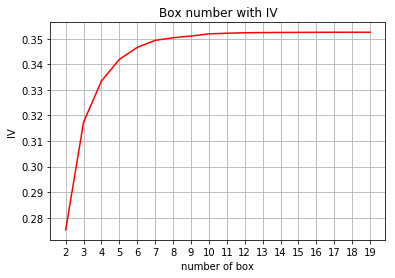

In [44]:
num_bins_ = num_bins.copy()#不希望覆盖源数据
import scipy.stats
IV = []
axisx = []

while len(num_bins_) > 2:#大于 设置的最低分箱个数
    pvs = []
    #获取 num_bins_两两之间的卡方检验的置信度（或者卡方值）
    for i in range(len(num_bins_) - 1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0 返回 chi2 值，1 返回 p 值。直接用p值进行判断就行
        pv = scipy.stats.chi2_contingency([x1,x2])[1]#p值
        pvs.append(pv)
    #合并P值最大的两组
    i = pvs.index(max(pvs))#P值最大的对象
    num_bins_[i:i+2] = [(
        num_bins_[i][0],
        num_bins_[i+1][1],
        num_bins_[i][2] + num_bins_[i+1][2],
        num_bins_[i][3] + num_bins_[i+1][3]
    )]
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
plt.figure()
plt.plot(axisx,IV,'r')
plt.xticks(axisx)
plt.title("Box number with IV")
plt.xlabel("number of box")
plt.ylabel("IV")
plt.grid()
plt.show()
#选择转折点处，也就是下坠最快的折线点，所以这里对于age来说选择箱数为6

# 3.5 定义最佳分箱函数，并验证分箱结果

In [45]:
def get_bin(num_bins_,n):
    while len(num_bins_) > n:
        pvs = []
        for i in range(len(num_bins_)-1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]#卡方检验
            # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins_[i:i+2] = [(
                num_bins_[i][0],
                num_bins_[i+1][1],
                num_bins_[i][2]+num_bins_[i+1][2],
                num_bins_[i][3]+num_bins_[i+1][3])]
    return num_bins_

In [46]:
afterbins = get_bin(num_bins,6)
afterbins

[(21.0, 36.0, 14797, 24871),
 (36.0, 54.0, 39070, 51370),
 (54.0, 61.0, 15743, 12258),
 (61.0, 64.0, 6968, 3198),
 (64.0, 74.0, 13376, 4222),
 (74.0, 107.0, 7737, 1398)]

In [47]:
bins_dfk = get_woe(afterbins)
bins_dfk

,min,max,count_0,count_1,total,percentage,good%,bad%,woe
0,21.0,36.0,14797,24871,39668,0.203417,0.151467,0.255567,-0.523114
1,36.0,54.0,39070,51370,90440,0.463776,0.399934,0.527863,-0.277535
2,54.0,61.0,15743,12258,28001,0.143589,0.161151,0.125959,0.246381
3,61.0,64.0,6968,3198,10166,0.052131,0.071327,0.032862,0.774967
4,64.0,74.0,13376,4222,17598,0.090242,0.136922,0.043384,1.149317
5,74.0,107.0,7737,1398,9135,0.046844,0.079199,0.014365,1.707136


希望每组的bad_rate相差越大越好。num_bins保留的信息越多越好

woe差异越大越好，应该具有单调性，随着箱的增加，要么由正到负，要么由负到正，只能有一个转折过程。如果woe值大小变化是有两个转折，比如呈现w型，证明分箱过程有问题

# 3.6 定义根据IV曲线选取每个特征的最佳分箱个数函数

结合3.1至3.5，将前面的过程封装为一个函数。

In [48]:
class Stack():   #定义类
    def __init__(self):  #产生一个空的容器
        self.__list = []
    def push(self, item):  #入栈
        self.__list.append(item)
    def pop(self):  #出栈
        return self.__list.pop()
    def speek(self):  #返回栈顶元素
        return self.__list[-1]
    def is_empty(self):  #判断是否已为空
        return not self.__list
    def size(self):  #返回栈中元素个数
        return len(self.__list)
    
def graphforbestbin(DF,X,Y,n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像
    区间为前开后闭 (]
    '''
    DF = DF[[X,Y]].copy()#[[X,Y]]是将这两列单独拼接成一个新的表
    #开始分箱
    DF['qcut'],bins = pd.qcut(DF[X],retbins=True,duplicates='drop',q=q)
    coount_y0 = DF.loc[DF[Y] == 0].groupby('qcut').count()[Y]#取出为0的计数结果
    coount_y1 = DF.loc[DF[Y] == 1].groupby('qcut').count()[Y]#取出为1的计数结果
    #将序列解压
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]
    
    #将num_bins合并直到没有0样本情况存在
    def get_newbins(bins):
        class Stack():
            #定义类
            def __init__(self):  #产生一个空的容器
                self.__list = []
            def push(self, item):  #入栈
                self.__list.append(item)
            def pop(self):  #出栈
                return self.__list.pop()
            def speek(self):  #返回栈顶元素
                return self.__list[-1]
            def is_empty(self):  #判断是否已为空
                return not self.__list
            def size(self):  #返回栈中元素个数
                return len(self.__list)

        s = Stack()
        #首先将列表翻转，降序
        bins = sorted(num_bins,reverse=True)
        #全部入栈
        for i in bins:
            s.push(i)
        lis =[]
        while not s.is_empty():
            s1 = s.pop()
            if 0 in s1[2:]:
                s2 = s.pop()
                s3 = (s1[0],s2[1],s1[2]+s2[2],s1[3]+s2[3])
                s.push(s3)
            else:
                lis.append(s1)
        return lis

    num_bins = get_newbins(num_bins)
    
    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]
        global bins_dfs
        bins_dfs = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_dfs))

    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.grid(True)
        plt.show()
    return bins_dfs





In [49]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''

    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]
        global bins_df
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))

    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.grid()
        plt.show()
    return bins_df

RevolvingUtilizationOfUnsecuredLines


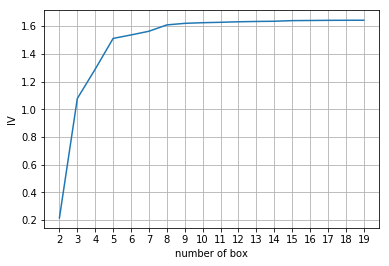

age


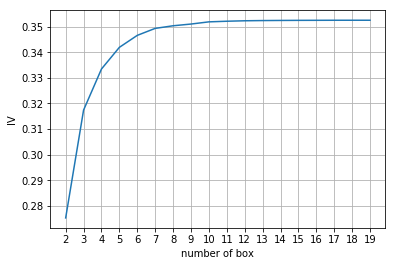

NumberOfTime30-59DaysPastDueNotWorse


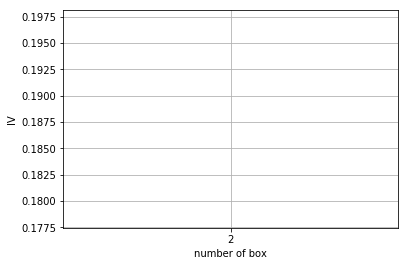

DebtRatio


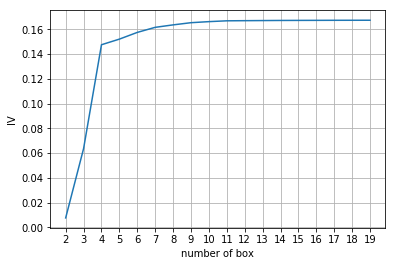

MonthlyIncome


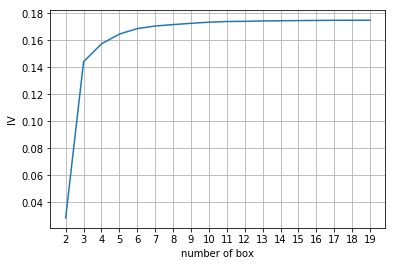

NumberOfOpenCreditLinesAndLoans


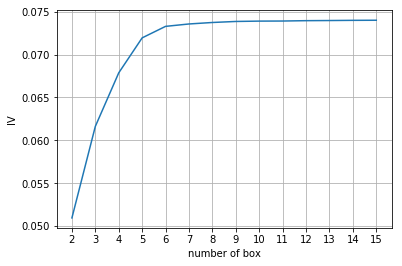

NumberOfTimes90DaysLate


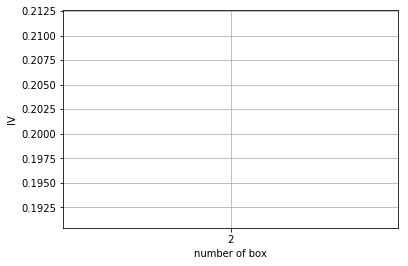

NumberRealEstateLoansOrLines


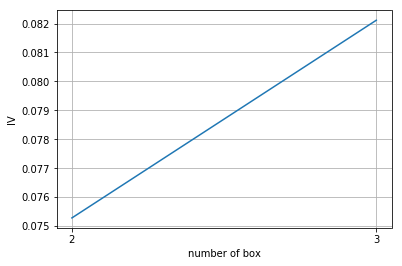

NumberOfTime60-89DaysPastDueNotWorse


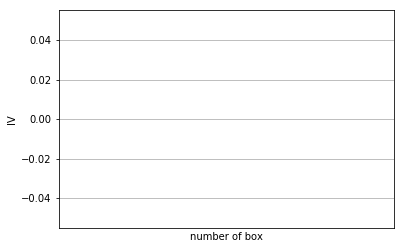

NumberOfDependents


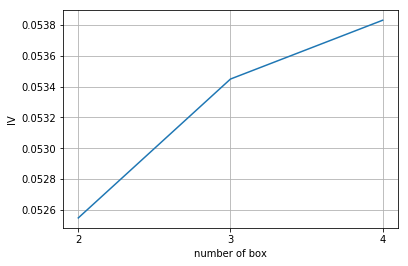

In [50]:
#model_data.columns

for i in model_data.columns[1:-1]:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)

我们发现，不是所有的特征都可以使用这个分箱函数，比如说有的特征，像家人数量，就无法分出20组。于是我们将可以分箱的特征放出来单独分组，不能自动分箱的变量自己观察然后手写：

In [51]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":5,
                "age":4,
                "DebtRatio":4,
                "MonthlyIncome":3,
                "NumberOfOpenCreditLinesAndLoans":5}
#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
            ,"NumberOfTimes90DaysLate":[0,2,17]
            ,"NumberRealEstateLoansOrLines":[0,1,2,3,32]
            ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,9]
            ,"NumberOfDependents":[0,1,2,3,20]}

#保证区间覆盖使用np.inf替换最大值，用-np.inf替换最小值 
#原因：比如一些新的值出现，例如家庭人数为30，以前没出现过
#改成范围为极大值之后，这些新值就都能分到箱里边了
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [52]:
#s手动检测数据分布，发现可以手动分成0,1,2,3，inf组也就是四组的样子,其他的变量类似。
model_data['NumberOfDependents'].describe([0,.15,.25,.35,.45,.55,.65,.75,.85,.95,1])


count    195008.000000
mean          0.837250
std           1.081516
min           0.000000
0%            0.000000
15%           0.000000
25%           0.000000
35%           0.000000
45%           0.000000
50%           0.257779
55.0%         0.635183
65%           1.000000
75%           1.430891
85%           2.000000
95%           3.000000
100%         20.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [53]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 3, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, 3, inf]}

接下来对所有特征按照选择的箱体个数和手写的分箱范围进行分箱：
[union函数](https://www.runoob.com/python3/ref-set-union.html)

In [54]:
bins_of_col = {}
#生成自动分箱的分享区间以及分箱后的IV值
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col,
                             "SeriousDlqin2yrs",
                             n=auto_col_bins[col],
                             q=20,
                             graph=False)
    bins_list = sorted(set(bins_df['min']).union(bins_df['max']))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list

#合并手动分箱数据    
bins_of_col.update(hand_bins)
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.098965834,
  0.2977134668,
  0.4650045383240421,
  0.9999998999999999,
  inf],
 'age': [-inf, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.0174052246,
  0.40159809604368835,
  1.4705647294000002,
  inf],
 'MonthlyIncome': [-inf, 0.10361295277515362, 5596.986324032611, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 3, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, 3, inf]}

# 3.7 计算各箱的WOE并映射到数据中
我们现在已经有了我们的箱子，接下来我们要做的是计算各箱的WOE，并且把WOE替换到我们的原始数据model_data中，因为我们将使用WOE覆盖后的数据来建模，我们希望获取的是”各个箱”的分类结果，即评分卡上各个评分项目的分类结果。

In [55]:
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = model_data.copy()
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = data[['age','SeriousDlqin2yrs']].copy()
data['cut'] = pd.cut(data['age'],[-np.inf, 36.0, 54.0, 61.0, 74.0, np.inf])
data.head()

,age,SeriousDlqin2yrs,cut
0,53,0,"(36.0, 54.0]"
1,63,0,"(61.0, 74.0]"
2,39,1,"(36.0, 54.0]"
3,73,0,"(61.0, 74.0]"
4,53,1,"(36.0, 54.0]"


In [56]:
#将数据按照分箱结果过聚合，并取出其中的标签值
data.groupby("cut")['SeriousDlqin2yrs'].value_counts()

cut           SeriousDlqin2yrs
(-inf, 36.0]  1                   24871
              0                   14797
(36.0, 54.0]  1                   51370
              0                   39070
(54.0, 61.0]  0                   15743
              1                   12258
(61.0, 74.0]  0                   20344
              1                    7420
(74.0, inf]   0                    7737
              1                    1398
Name: SeriousDlqin2yrs, dtype: int64

In [57]:
#使用unstack()来将树状结构变为表结构
data.groupby("cut")['SeriousDlqin2yrs'].value_counts().unstack()
bins_df = data.groupby("cut")['SeriousDlqin2yrs'].value_counts().unstack()
bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 36.0]",14797,24871,-0.523114
"(36.0, 54.0]",39070,51370,-0.277535
"(54.0, 61.0]",15743,12258,0.246381
"(61.0, 74.0]",20344,7420,1.004771
"(74.0, inf]",7737,1398,1.707136


把以上计算一个特征中所有woe值的过程包装成函数：

In [58]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df['cut'] = pd.cut(df[col],bins)
    bins_df = df.groupby('cut')[y].value_counts().unstack()
    woe = bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe
#将所有的特征的woe储存在字典当中。
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.099]     2.198459
 (0.099, 0.298]    0.669123
 (0.298, 0.465]   -0.126341
 (0.465, 1.0]     -0.944944
 (1.0, inf]       -2.037817
 dtype: float64, 'age': cut
 (-inf, 54.0]   -0.351217
 (54.0, 61.0]    0.246381
 (61.0, 74.0]    1.004771
 (74.0, inf]     1.707136
 dtype: float64, 'DebtRatio': cut
 (-inf, 0.0174]     1.509166
 (0.0174, 0.402]    0.036123
 (0.402, 1.471]    -0.388106
 (1.471, inf]       0.175816
 dtype: float64, 'MonthlyIncome': cut
 (-inf, 0.104]        1.466756
 (0.104, 5596.986]   -0.239060
 (5596.986, inf]      0.230629
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.852144
 (1.0, 3.0]    -0.325332
 (3.0, 5.0]    -0.052963
 (5.0, 17.0]    0.122589
 (17.0, inf]    0.468403
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.353370
 (0.0, 1.0]    -0.876355
 (1.0, 2.0]    -1.374281
 (2.0, inf]    -1.540354
 dtype: float64, 'NumberOfTimes90DaysLate': cut
 (-inf, 0.0]

In [59]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.098965834,
  0.2977134668,
  0.4650045383240421,
  0.9999998999999999,
  inf],
 'age': [-inf, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.0174052246,
  0.40159809604368835,
  1.4705647294000002,
  inf],
 'MonthlyIncome': [-inf, 0.10361295277515362, 5596.986324032611, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 3, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, 3, inf]}

In [60]:
a=iter(woeall)
next(a)


'RevolvingUtilizationOfUnsecuredLines'

In [61]:
woeall['RevolvingUtilizationOfUnsecuredLines']

cut
(-inf, 0.099]     2.198459
(0.099, 0.298]    0.669123
(0.298, 0.465]   -0.126341
(0.465, 1.0]     -0.944944
(1.0, inf]       -2.037817
dtype: float64

In [62]:
type(woeall['RevolvingUtilizationOfUnsecuredLines'])

pandas.core.series.Series

In [63]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 3, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, 3, inf]}

# 3.7 计算各箱的WOE并映射到数据中
我们现在已经有了我们的箱子，接下来我们要做的是计算各箱的WOE，并且把WOE替换到我们的原始数据model_data中，因为我们将使用WOE覆盖后的数据来建模，我们希望获取的是”各个箱”的分类结果，即评分卡上各个评分项目的分类结果。

In [64]:
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = model_data.copy()
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = data[['age','SeriousDlqin2yrs']].copy()
data['cut'] = pd.cut(data['age'],[-np.inf, 36.0, 54.0, 61.0, 74.0, np.inf])
data.head()

,age,SeriousDlqin2yrs,cut
0,53,0,"(36.0, 54.0]"
1,63,0,"(61.0, 74.0]"
2,39,1,"(36.0, 54.0]"
3,73,0,"(61.0, 74.0]"
4,53,1,"(36.0, 54.0]"


In [65]:
#将数据按照分箱结果过聚合，并取出其中的标签值
data.groupby("cut")['SeriousDlqin2yrs'].value_counts()

cut           SeriousDlqin2yrs
(-inf, 36.0]  1                   24871
              0                   14797
(36.0, 54.0]  1                   51370
              0                   39070
(54.0, 61.0]  0                   15743
              1                   12258
(61.0, 74.0]  0                   20344
              1                    7420
(74.0, inf]   0                    7737
              1                    1398
Name: SeriousDlqin2yrs, dtype: int64

In [66]:
#使用unstack()来将树状结构变为表结构
data.groupby("cut")['SeriousDlqin2yrs'].value_counts().unstack()
bins_df = data.groupby("cut")['SeriousDlqin2yrs'].value_counts().unstack()
bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 36.0]",14797,24871,-0.523114
"(36.0, 54.0]",39070,51370,-0.277535
"(54.0, 61.0]",15743,12258,0.246381
"(61.0, 74.0]",20344,7420,1.004771
"(74.0, inf]",7737,1398,1.707136


把以上计算一个特征中所有woe值的过程包装成函数：

In [67]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df['cut'] = pd.cut(df[col],bins)
    bins_df = df.groupby('cut')[y].value_counts().unstack()
    woe = bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe
#将所有的特征的woe储存在字典当中。
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
woeall


{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.099]     2.198459
 (0.099, 0.298]    0.669123
 (0.298, 0.465]   -0.126341
 (0.465, 1.0]     -0.944944
 (1.0, inf]       -2.037817
 dtype: float64, 'age': cut
 (-inf, 54.0]   -0.351217
 (54.0, 61.0]    0.246381
 (61.0, 74.0]    1.004771
 (74.0, inf]     1.707136
 dtype: float64, 'DebtRatio': cut
 (-inf, 0.0174]     1.509166
 (0.0174, 0.402]    0.036123
 (0.402, 1.471]    -0.388106
 (1.471, inf]       0.175816
 dtype: float64, 'MonthlyIncome': cut
 (-inf, 0.104]        1.466756
 (0.104, 5596.986]   -0.239060
 (5596.986, inf]      0.230629
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.852144
 (1.0, 3.0]    -0.325332
 (3.0, 5.0]    -0.052963
 (5.0, 17.0]    0.122589
 (17.0, inf]    0.468403
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.353370
 (0.0, 1.0]    -0.876355
 (1.0, 2.0]    -1.374281
 (2.0, inf]    -1.540354
 dtype: float64, 'NumberOfTimes90DaysLate': cut
 (-inf, 0.0]

In [68]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)
#将元数据分箱后，按照箱子的结果吧woe结构用针对SEries的apply函数映射到数据中
model_woe['age'] = pd.cut(model_data['age'],bins_of_col['age']).apply(woeall['age'])
model_woe.head()

,age
0,-0.351217
1,1.004771
2,-0.351217
3,1.004771
4,-0.351217


In [69]:
#对所有的特征操作可以写成
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).apply(woeall[col])
#添加标签
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.351217,2.198459,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083,0
1,1.004771,0.669123,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083,0
2,-0.351217,-2.037817,-0.388106,-0.239060,-0.052963,-0.876355,-1.865762,-0.393518,-1.779985,-0.417667,1
3,1.004771,2.198459,-0.388106,-0.239060,0.122589,0.353370,0.234152,0.617593,0.124138,0.626083,0
4,-0.351217,-0.944944,-0.388106,0.230629,0.122589,0.353370,0.234152,0.617593,0.124138,-0.581918,1


此即为我们的建模数据

终于弄完了我们的训练集，接下来我们要处理测试集，在已经有分箱的情况下，测试集的处理就非常简单了，我们只需要将已经计算好的WOE映射到测试集中去就可以了



In [70]:
vali_data = pd.read_csv("vali_data.csv")
vali_woe = pd.DataFrame(index=vali_data.index)

for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])

vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [71]:
vali_woe.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,2.198459,0.246381,1.509166,-0.239060,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083,0
1,-0.944944,-0.351217,0.036123,0.230629,0.122589,0.35337,0.234152,0.617593,0.124138,-0.497888,1
2,2.198459,1.004771,0.036123,0.230629,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083,0
3,2.198459,-0.351217,0.036123,-0.239060,0.122589,0.35337,0.234152,0.195848,0.124138,0.626083,0
4,-0.944944,-0.351217,0.036123,-0.239060,0.122589,0.35337,0.234152,-0.393518,0.124138,-0.581918,1


In [72]:
vali_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83576 entries, 0 to 83575
Data columns (total 11 columns):
RevolvingUtilizationOfUnsecuredLines    83576 non-null float64
age                                     83576 non-null float64
DebtRatio                               83576 non-null float64
MonthlyIncome                           83576 non-null float64
NumberOfOpenCreditLinesAndLoans         83576 non-null float64
NumberOfTime30-59DaysPastDueNotWorse    83576 non-null float64
NumberOfTimes90DaysLate                 83576 non-null float64
NumberRealEstateLoansOrLines            83576 non-null float64
NumberOfTime60-89DaysPastDueNotWorse    83576 non-null float64
NumberOfDependents                      83576 non-null float64
SeriousDlqin2yrs                        83576 non-null int64
dtypes: float64(10), int64(1)
memory usage: 7.0 MB


In [73]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 12 columns):
SeriousDlqin2yrs                        195008 non-null int64
RevolvingUtilizationOfUnsecuredLines    195008 non-null float64
age                                     195008 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    195008 non-null int64
DebtRatio                               195008 non-null float64
MonthlyIncome                           195008 non-null float64
NumberOfOpenCreditLinesAndLoans         195008 non-null int64
NumberOfTimes90DaysLate                 195008 non-null int64
NumberRealEstateLoansOrLines            195008 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    195008 non-null int64
NumberOfDependents                      195008 non-null float64
qcut                                    195008 non-null category
dtypes: category(1), float64(4), int64(7)
memory usage: 16.6 MB


# 4. 建立模型与模型验证

In [74]:
#尝试使用命名切片
WithOutLastOne = slice(-1)
OnlyLastOne = slice(-1,None)



vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
#交换age列，是训练数据与测试数据一一对应
mid = vali_X['age']
vali_X.drop(labels = "age",axis=1,inplace=True)
vali_X.insert(0,"age",mid)

from sklearn.linear_model import LogisticRegression as LR

lr = LR(penalty="l2").fit(X,y)
lr.score(vali_X,vali_y)

0.7817914233751316

In [75]:
X.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,-0.351217,2.198459,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083
1,1.004771,0.669123,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083
2,-0.351217,-2.037817,-0.388106,-0.239060,-0.052963,-0.876355,-1.865762,-0.393518,-1.779985,-0.417667
3,1.004771,2.198459,-0.388106,-0.239060,0.122589,0.353370,0.234152,0.617593,0.124138,0.626083
4,-0.351217,-0.944944,-0.388106,0.230629,0.122589,0.353370,0.234152,0.617593,0.124138,-0.581918


In [76]:
help(LR)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
 |  that regularization is applied by default**. It can handle both dense
 |  and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
 |  floats for optimal performance; any other input format will be conv

In [77]:
vali_X.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.246381,2.198459,1.509166,-0.239060,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083
1,-0.351217,-0.944944,0.036123,0.230629,0.122589,0.35337,0.234152,0.617593,0.124138,-0.497888
2,1.004771,2.198459,0.036123,0.230629,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083
3,-0.351217,2.198459,0.036123,-0.239060,0.122589,0.35337,0.234152,0.195848,0.124138,0.626083
4,-0.351217,-0.944944,0.036123,-0.239060,0.122589,0.35337,0.234152,-0.393518,0.124138,-0.581918


In [78]:
#尝试交换列
es = vali_X.copy()
mid = es['age']
es.drop(labels="age",axis=1,inplace=True)
es.insert(0,"age",mid)
es.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.246381,2.198459,1.509166,-0.239060,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083
1,-0.351217,-0.944944,0.036123,0.230629,0.122589,0.35337,0.234152,0.617593,0.124138,-0.497888
2,1.004771,2.198459,0.036123,0.230629,-0.052963,0.35337,0.234152,-0.393518,0.124138,0.626083
3,-0.351217,2.198459,0.036123,-0.239060,0.122589,0.35337,0.234152,0.195848,0.124138,0.626083
4,-0.351217,-0.944944,0.036123,-0.239060,0.122589,0.35337,0.234152,-0.393518,0.124138,-0.581918


In [79]:
X.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,-0.351217,2.198459,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083
1,1.004771,0.669123,0.036123,-0.239060,-0.052963,0.353370,0.234152,-0.393518,0.124138,0.626083
2,-0.351217,-2.037817,-0.388106,-0.239060,-0.052963,-0.876355,-1.865762,-0.393518,-1.779985,-0.417667
3,1.004771,2.198459,-0.388106,-0.239060,0.122589,0.353370,0.234152,0.617593,0.124138,0.626083
4,-0.351217,-0.944944,-0.388106,0.230629,0.122589,0.353370,0.234152,0.617593,0.124138,-0.581918


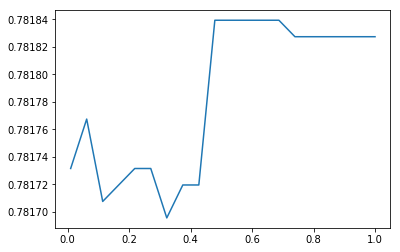

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

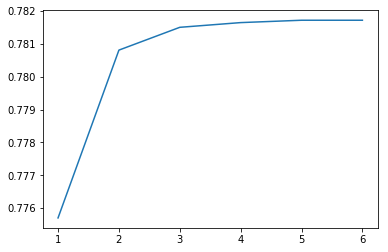

In [80]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

score = []
for i in c_2: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_1,score)
plt.show()

lr.n_iter_

score = []
for i in [1,2,3,4,5,6]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6],score)
plt.show()

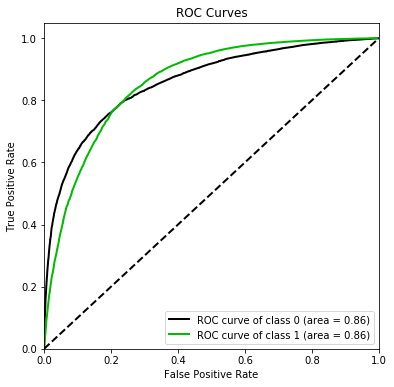

In [81]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))

skplt.metrics.plot_roc(vali_y, vali_proba_df,
                        plot_micro=False,figsize=(6,6),
                        plot_macro=False)

现在的问题是这样子的,我电脑上有2个python，然后还有2个虚拟环境，我现在pip是在往annoconda的里面装，但是我在用房的环境并没有装，还得手动去复制过来，佛了


# 5. 评分卡制作

In [82]:
"""600 =x1 - x2*np.log(1/60)
620 = x1 - x2*np.log(1/30)
x1,x2"""
#求解
x = np.array([[1,-np.log(1/60)],[1,-np.log(1/30)]])
b = np.array([600,620])
A,B = np.linalg.solve(x,b)

有了x1和x2，分数就很容易得到了。其中不受评分卡中各特征影响的基础分，就是将截距作为 log(odds)带入公式进行计算，而其他各个特征各个分档的分数，也是将系数带入进行计算：

In [83]:
base_score = A - B*lr.intercept_
base_score

array([718.04690897])

In [84]:
score_age = woeall['age'] * (-B * lr.coef_[0][1])
score_age

cut
(-inf, 54.0]     7.577264
(54.0, 61.0]    -5.315505
(61.0, 74.0]   -21.677239
(74.0, inf]    -36.830261
dtype: float64

我们可以通过循环，将所有特征的评分卡内容全部一次性写往一个本地文件ScoreData.csv：

In [93]:
file = "./ScoreData.csv "

with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
score.to_csv(file,header=True,mode="w")

In [95]:
lr.coef_

array([[-0.28896348, -0.74770836, -0.77902149, -0.50947876, -0.1218577 ,
        -0.54959084, -0.54953426, -0.95986095, -0.2827806 , -0.80002357]])